# To install database (from kaggle)



In [ ]:
# Install Kaggle API and set up credentials
from google.colab import files
import os

# Upload your kaggle.json file
print("Upload your kaggle.json file.")
files.upload()  # Upload your kaggle.json file here

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle API
!pip install -q kaggle

# Download the Lettuce Disease dataset from Kaggle
!kaggle datasets download -d ashishjstar/lettuce-diseases

# Extract the dataset
!unzip lettuce-diseases.zip -d lettuce_disease_data

Upload your kaggle.json file.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ashishjstar/lettuce-diseases
License(s): apache-2.0
 99% 1.24G/1.25G [00:22<00:00, 96.9MB/s]
100% 1.25G/1.25G [00:22<00:00, 58.8MB/s]
Archive:  lettuce-diseases.zip
  inflating: lettuce_disease_data/Lettuce_disease_datasets/Bacterial/bct (1).jpg  
  inflating: lettuce_disease_data/Lettuce_disease_datasets/Bacterial/bct (10).jpg  
  inflating: lettuce_disease_data/Lettuce_disease_datasets/Bacterial/bct (11).jpg  
  inflating: lettuce_disease_data/Lettuce_disease_datasets/Bacterial/bct (12).jpg  
  inflating: lettuce_disease_data/Lettuce_disease_datasets/Bacterial/bct (13).jpg  
  inflating: lettuce_disease_data/Lettuce_disease_datasets/Bacterial/bct (14).jpg  
  inflating: lettuce_disease_data/Lettuce_disease_datasets/Bacterial/bct (15).jpg  
  inflating: lettuce_disease_data/Lettuce_disease_datasets/Bacterial/bct (16).jpg  
  inflating: lettuce_disease_data/Lettuce_disease_datasets/Bacterial/bct (17).jpg  
 

# Binary segmentation of data into healthy and non-healthy

In [ ]:
import shutil
import random

# Define source and target directories
source_dir = "/content/lettuce_disease_data/Lettuce_disease_datasets"
train_dir = "/content/lettuce_disease_data/train"
validation_dir = "/content/lettuce_disease_data/validation"
test_dir = "/content/lettuce_disease_data/test"


In [ ]:
# Create directories for binary classification.
# Basicamente crea los folders para poner las imagenes clasificadas.
os.makedirs(f"{train_dir}/healthy", exist_ok=True)
os.makedirs(f"{train_dir}/non_healthy", exist_ok=True)
os.makedirs(f"{validation_dir}/healthy", exist_ok=True)
os.makedirs(f"{validation_dir}/non_healthy", exist_ok=True)
os.makedirs(f"{test_dir}/healthy", exist_ok=True)
os.makedirs(f"{test_dir}/non_healthy", exist_ok=True)


In [ ]:

# Split the dataset into train, validation, and test sets
healthy_classes = ["Healthy"]  # Specify the class for healthy lettuce

# Go through the files
for disease_class in os.listdir(source_dir):
    disease_class_path = os.path.join(source_dir, disease_class)
    if os.path.isdir(disease_class_path):
        images = os.listdir(disease_class_path)
        random.shuffle(images)

        train_split = int(0.8 * len(images))
        val_split = int(0.9 * len(images))

        # Determine target class (healthy or non_healthy)
        target_class = "healthy" if disease_class in healthy_classes else "non_healthy"

        # Move images to respective directories
        for img in images[:train_split]:
            shutil.copy(os.path.join(disease_class_path, img), f"{train_dir}/{target_class}")
        for img in images[train_split:val_split]:
            shutil.copy(os.path.join(disease_class_path, img), f"{validation_dir}/{target_class}")
        for img in images[val_split:]:
            shutil.copy(os.path.join(disease_class_path, img), f"{test_dir}/{target_class}")


# Data generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation applied to the training set (data normalization)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,              # Normalize pixel values to [0, 1]
    rotation_range=40,            # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,        # Randomly shift images horizontally by 20% of width
    height_shift_range=0.2,       # Randomly shift images vertically by 20% of height
    shear_range=0.2,              # Randomly shear images
    zoom_range=0.2,               # Randomly zoom in on images
    horizontal_flip=True,         # Randomly flip images horizontally
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    fill_mode='nearest'           # Fill in missing pixels after transformations
)

# Validation and test sets only rescale images (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [ ]:

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'  # Binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 1867 images belonging to 2 classes.
Found 234 images belonging to 2 classes.
Found 236 images belonging to 2 classes.


MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.8111 - loss: 0.6087 - val_accuracy: 0.9554 - val_loss: 0.1418
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9375 - loss: 0.1178 - val_accuracy: 1.0000 - val_loss: 0.0132
Epoch 3/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


58/58 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.9723 - loss: 0.0870 - val_accuracy: 0.9777 - val_loss: 0.0683
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 1.5649e-04
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.9749 - loss: 0.0642 - val_accuracy: 0.9777 - val_loss: 0.0568
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9375 - loss: 0.1055 - val_accuracy: 1.0000 - val_loss: 7.3788e-04
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9723 - loss: 0.0742 - val_accuracy: 0.9821 - val_loss: 0.0613
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9375 - loss: 0.1326 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 9/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.9814 - loss: 0.0670 - val_accuracy: 0.9777 - val_loss: 0.0757


Summary

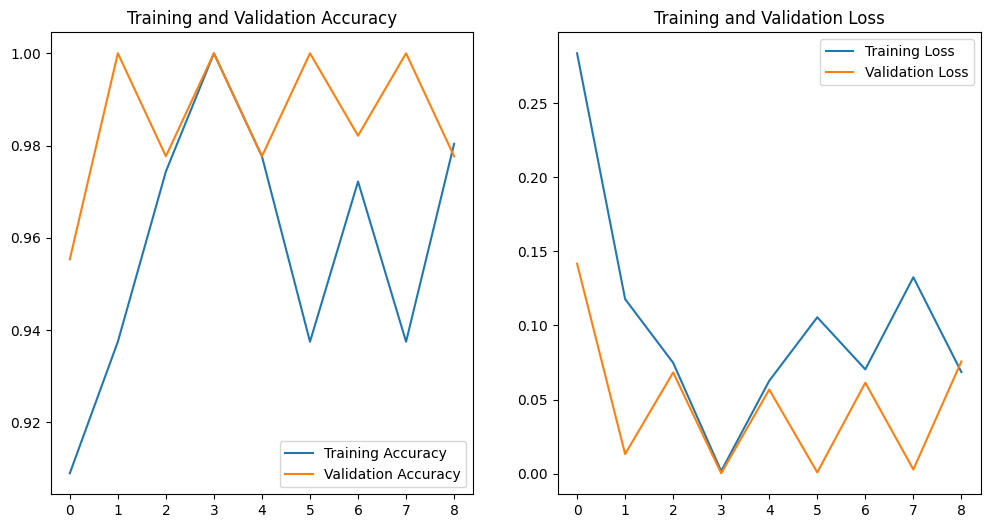

In [ ]:
# Plot training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 924ms/step


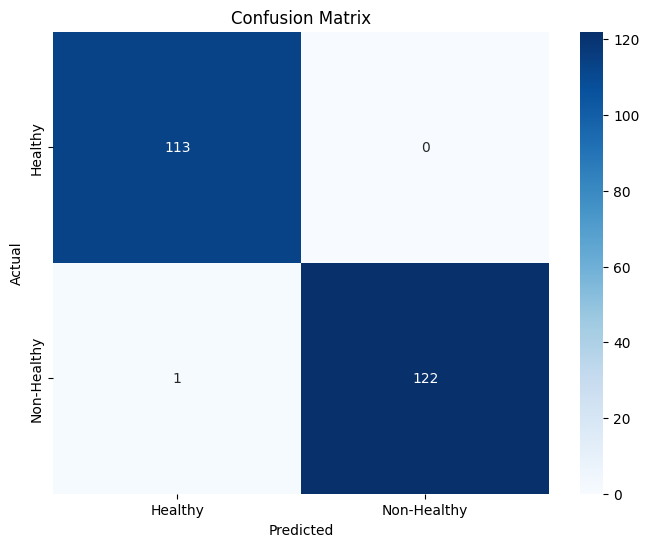

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00       113
 Non-Healthy       1.00      0.99      1.00       123

    accuracy                           1.00       236
   macro avg       1.00      1.00      1.00       236
weighted avg       1.00      1.00      1.00       236



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Generate the confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm_labels = ["Healthy", "Non-Healthy"]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=cm_labels))


In [ ]:
print("Class Distribution in Training Set:")
for label, count in train_generator.class_indices.items():
    print(f"{label}: {sum(train_generator.classes == count)} images")


Class Distribution in Training Set:
healthy: 898 images
non_healthy: 969 images


In [ ]:
# Save the model
model.save("healthy_vs_non_healthy_classifier.h5")
print("Model saved as healthy_vs_non_healthy_classifier.h5")


Model saved as healthy_vs_non_healthy_classifier.h5


TEST

In [ ]:
from google.colab import files
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reload the trained model
model = tf.keras.models.load_model("healthy_vs_non_healthy_classifier.h5")

# Function to classify an uploaded image
def classify_uploaded_image(model, img_path):
    # Load the image using Pillow (PIL)
    img = Image.open(img_path).convert('RGB')  # Convert to RGB to ensure 3 channels
    img = img.resize((150, 150))  # Resize to model's input size
    img_array = np.array(img)  # Convert image to NumPy array
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make predictions
    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        result = "Non-Healthy"
        confidence = prediction[0][0] * 100
    else:
        result = "Healthy"
        confidence = (1 - prediction[0][0]) * 100

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {result} ({confidence:.2f}% confidence)")
    plt.show()

    print(f"The uploaded lettuce is classified as: {result}")
    print(f"Confidence score: {confidence:.2f}%")


NameError: name 'model' is not defined

In [ ]:
# Upload the image
print("Please upload an image:")
uploaded = files.upload()

# Get the uploaded file's path
for filename in uploaded.keys():
    img_path = filename  # Use the filename directly as the path

# Classify the uploaded image
classify_uploaded_image(model, img_path)


Please upload an image:


NameError: name 'files' is not defined